3. Do a bit of research on similar problems such as named entity recognition, find a dataset, train a model, and report your results.

In [7]:
# https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54
# f = open("ner_dataset.csv",'r')
# print(f.readline())
# # f.read
# # count = 0
# for i in f:
#     print(i)
#     break
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [13]:
# from itertools import chain
# def get_dict_map(data, token_or_tag):
#     tok2idx = {}
#     idx2tok = {}
    
#     if token_or_tag == 'token':
#         vocab = list(set(data['Word'].to_list()))
#     else:
#         vocab = list(set(data['POS'].to_list()))
    
#     idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
#     tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
#     return tok2idx, idx2tok


# token2idx, idx2token = get_dict_map(data, 'token')
# tag2idx, idx2tag = get_dict_map(data, 'tag')

# data['Word_idx'] = data['Word'].map(token2idx)
# data['Tag_idx'] = data['POS'].map(tag2idx)
# data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,21975,33
1,NaN,of,IN,O,8476,0
2,NaN,demonstrators,NNS,O,29607,33
3,NaN,have,VBP,O,2568,39
4,NaN,marched,VBN,O,19932,12


In [21]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # A bit more efficient than normal Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # print(input.shape, hidden.shape)
        combined = torch.cat((input, hidden), 1)
        a = self.i2h(combined)
        hidden = torch.tanh(a)
        o = self.h2o(hidden)
        y_hat = self.softmax(o)
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)
        # output = self.softmax(output)
        return y_hat, hidden

    def initHidden(self, batch_size = 1):
        return torch.zeros(batch_size, self.hidden_size)

In [32]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch


# Util Functions
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i




# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# Prepare Data
all_letters = string.ascii_letters + " .,;'"

category_lines = {}
all_categories = []

n_letters = len(all_letters)

for pos in list(set(data['POS'].to_list())):
    category_lines[pos] = []
    all_categories.append(pos)

for word,pos in zip(data['Word'].to_list(),data['POS'].to_list()):
    category_lines[pos].append(word)


# for filename in findFiles('data/names/*.txt'):
#     category = os.path.splitext(os.path.basename(filename))[0]
#     all_categories.append(category)
#     lines = readLines(filename)
#     category_lines[category] = lines


n_categories = len(all_categories)

# n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)

In [33]:
# https://www.marktechpost.com/2020/04/12/implementing-batching-for-seq2seq-models-in-pytorch/
def batched_lines(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

def print_char(name_reps):
    # name_reps = name_reps.view((-1, name_reps.size()[-1]))
    # print(name_reps)
    for t in name_reps: 
        # if torch.sum(t) == 0:
        #     print('')
        # else:
            index = t.argmax()
            print(all_letters[index])

def batched_categories(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

In [34]:
# out = batched_lines(['Shyam','Ram'],9)
# print(out.shape)

# print_char(out[:,0,:])
# print()
# print_char(out[:,1,:])

In [35]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn = rnn.to('cuda:1')

import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(batch_size = 1):
    if(batch_size == 1):
        category = randomChoice(all_categories)
        line = randomChoice(category_lines[category])
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line)
        return category, line, category_tensor, line_tensor
    else:
        max_length = 0
        categories = []
        lines = []
        lines_length = []
        for i in range(batch_size):
            category = randomChoice(all_categories)
            line = randomChoice(category_lines[category])
            categories.append(category)
            lines.append(line)
            lines_length.append(len(line))
            if(len(line) > max_length): max_length = len(line)
        line_tensor = batched_lines(lines,max_length)
        category_tensor = batched_categories(categories)
        # padded_line_tensor = torch.nn.utils.rnn.pack_padded_sequence(line_tensor, lines_length, enforce_sorted = False)
        return categories, lines, category_tensor, line_tensor

# for i in range(10):
# category, line, category_tensor, line_tensor = randomTrainingExample(10)
# print(category_tensor.shape, line_tensor.shape)
#     print('category =', category, '/ line =', line)

# If use softmax -> corss entropy
# If use logsoftmax -> negative log likelihood loss
criterion = nn.NLLLoss()

torch.Size([10]) torch.Size([11, 10, 57])


In [36]:
# input = letterToTensor('B').to('cuda:1')
# hidden = torch.zeros(1, n_hidden).to('cuda:1')
# print(input)
# output, next_hidden = rnn(input, hidden)
# output

In [37]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(line_tensor.shape[1]).to('cuda:1')

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [38]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
rnn = rnn.to('cuda:1')

batch_size = 10
# n_iters = int(n_iters / batch_size)
# print_every = int(print_every / batch_size)
# plot_every = int(plot_every / batch_size)

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(batch_size)
    # print(type(category_tensor.to('cuda:1')), type(line_tensor))

    output, loss = train(category_tensor.to('cuda:1'), line_tensor.to('cuda:1'))
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 3.7332 ['Barack', ',', '"', 'began', 'calls', 'least', 'all', 'States', 'he', 'most'] / RRB ✗ (['NNP', ',', '``', 'VBD', 'VBZ', 'JJS', 'PDT', 'NNPS', 'PRP', 'JJS'])
10000 10% (0m 22s) 3.5681 ['whose', ';', '.', 'An', ';', 'its', 'all', 'chief', 'have', 'making'] / `` ✗ (['WP$', ';', '.', 'DT', ';', 'PRP$', 'PDT', 'JJ', 'VBP', 'VBG'])
15000 15% (0m 33s) 2.4374 ['$', 'smuggling', 'argues', 'security', ',', 'perestroika', '"', 'attend', '-', ','] / $ ✗ (['$', 'VBG', 'VBZ', 'NN', ',', 'FW', '``', 'VB', ':', ','])
20000 20% (0m 45s) 2.3384 ['thousands', ';', 'demobilized', 'perestroika', 'never', 'they', 'most', ',', 'as', 'swing'] / WRB ✗ (['NNS', ';', 'VBN', 'FW', 'RB', 'PRP', 'RBS', ',', 'RB', 'NN'])
25000 25% (0m 56s) 1.3747 ['more', "'s", 'Yes', 'earlier', 'least', 'who', 'five', 'were', 'up', 'most'] / JJR ✗ (['JJR', 'POS', 'UH', 'JJR', 'JJS', 'WP', 'CD', 'VBD', 'RP', 'RBS'])
30000 30% (1m 7s) 1.6465 ['out', 'be', 'out', ')', 'Oh', 'Iraq', 'militants', 'where', 'affec

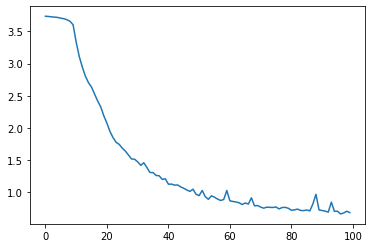

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


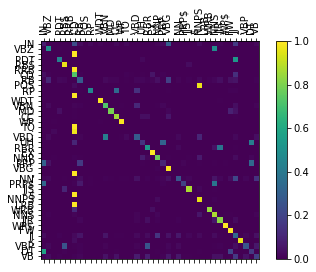

In [40]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to('cuda:1')

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor.to('cuda:1'))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [45]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line).to('cuda:1'))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('eat')
predict('eats')
predict('eatting')
predict('ate')
predict('eatten')


> eat
(-0.98) JJR
(-1.92) RB
(-2.28) NN

> eats
(-0.12) NNS
(-3.54) VBZ
(-3.82) NNPS

> eatting
(-0.05) VBG
(-3.83) NN
(-4.43) JJ

> ate
(-2.03) JJR
(-2.11) FW
(-2.29) RBS

> eatten
(-0.99) JJR
(-1.93) JJ
(-2.00) RBR
